**AIM:-**

1.   **Train a simple vgg16 model to identify Car Or Plane.**
2.   **this training will be done without fine tuning.**
3.   **perform quantization and prunning on the model to reduce its size.**
4.   **perform inference on the quantized model to see if it gives correct prediction.**





In [1]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [2]:
! pip install -q tensorflow-model-optimization

     |████████████████████████████████| 211 kB 5.3 MB/s 


In [3]:
import tensorflow_model_optimization as tfmot

In [4]:
from keras.layers import Input, Lambda, Dense, Flatten,InputLayer,Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
from keras.callbacks import EarlyStopping
from keras import optimizers
import pandas as pd
import math
from keras.models import model_from_json


In [5]:

print(keras.__version__)

2.6.0


**mount google drive on collab**

In [6]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/
Mounted at /content/gdrive


In [7]:
%cd /content/

/content


**unzip the folder which contains training data**

**the folder structure should be like below  for train data,test data and validation data. In this example i have kept data in the jpeg format**

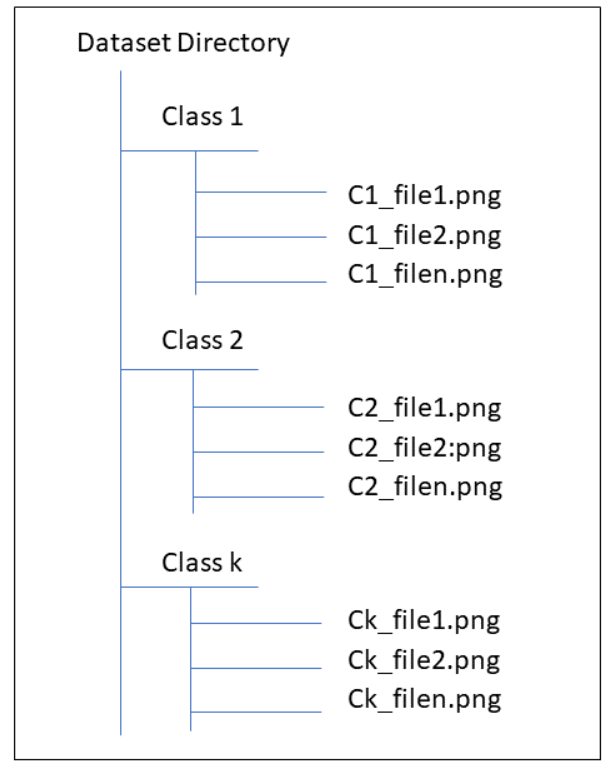

In [8]:
!unzip gdrive/My\ Drive/vgg16_dataset/dataset3a.zip

Archive:  gdrive/My Drive/vgg16_dataset/dataset3a.zip
   creating: train/plane/
  inflating: train/plane/PLANE1.jpg  
  inflating: train/plane/PLANE10.jpg  
  inflating: train/plane/PLANE100.jpg  
  inflating: train/plane/PLANE103.jpg  
  inflating: train/plane/PLANE106.jpg  
  inflating: train/plane/PLANE107.jpg  
  inflating: train/plane/PLANE108.jpg  
  inflating: train/plane/PLANE109.jpg  
  inflating: train/plane/PLANE11.jpg  
  inflating: train/plane/PLANE110.jpg  
  inflating: train/plane/PLANE1100.jpg  
  inflating: train/plane/PLANE1101.jpg  
  inflating: train/plane/PLANE1102.jpg  
  inflating: train/plane/PLANE1103.jpg  
  inflating: train/plane/PLANE1104.jpg  
  inflating: train/plane/PLANE1105.jpg  
  inflating: train/plane/PLANE1106.jpg  
  inflating: train/plane/PLANE1107.jpg  
  inflating: train/plane/PLANE1108.jpg  
  inflating: train/plane/PLANE1109.jpg  
  inflating: train/plane/PLANE111.jpg  
  inflating: train/plane/PLANE1110.jpg  
  inflating: train/plane/PLANE111

In [9]:
!pwd

/content


**time to load data into collab. Here we will use image data generator class. this is because of the structure of our train, test and validation folder**

**if you want more information on this class, then you should read this blog [link text](https://towardsdatascience.com/image-data-generators-in-keras-7c5fc6928400)**

In [10]:
batch_size=32
trdata = ImageDataGenerator(zoom_range=0.3, rotation_range=50,preprocessing_function=preprocess_input,
                                   width_shift_range=0.2, height_shift_range=0.2, #shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')
traindata = trdata.flow_from_directory(directory="train",batch_size=batch_size,target_size=(224,224),class_mode='categorical')
tsdata = ImageDataGenerator(preprocessing_function=preprocess_input)
validdata = tsdata.flow_from_directory(directory="validation",batch_size=batch_size, target_size=(224,224),class_mode='categorical')

Found 962 images belonging to 2 classes.
Found 140 images belonging to 2 classes.


**its time to load vgg16 architecture on collab. Include false will not load fully connected layer. this will enable us to train the network for required number of class. for more information on this visit this site[link text](https://towardsdatascience.com/image-data-generators-in-keras-7c5fc6928400)**

In [11]:
input_shape = (224, 224, 3)
vgg = VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

58900480/58889256 [==============================] - 1s 0us/step


**lets see the structure of the VGG16, we can see that the fully connected layer is not present. this last layer has to be connected to the fully connected layer that we will design**

In [12]:
vgg.summary()   ##in case of confusion uncomment the code

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

**lets flatten the last layer and connect it to our fully connected layer**

**in this we will freeze all the layer so that weights of this layer dont change. we will also design the fully connected layer according to the number of classes we have.**

In [16]:
###for general model tuning

output = vgg.layers[-1].output #taking output shape of the last layer i.e maxpool
output = keras.layers.Flatten()(output) #flatening the last layer
vgg_model = Model(vgg.input, output) #defining how the input and output are. input= first layer ,output=flaten last layer

vgg_model.trainable = False  #ensuring that the weights dont change.
for layer in vgg_model.layers: #making all layers trainable as false 
    layer.trainable = False
input_shape = vgg_model.output_shape[1]
model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
#model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))

#model.compile(loss='binary_crossentropy',
#              optimizer=optimizers.RMSprop(learning_rate=1e-4),
#              metrics=['accuracy'])
#
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Functional)         (None, 25088)             14714688  
_________________________________________________________________
dense_3 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1026      
Total params: 27,823,938
Trainable params: 13,109,250
Non-trainable params: 14,714,688
_________________________________________________________________


**the code below is for stopping the training if there is no imporvement in the model performance** 

In [17]:
custom_early_stopping = EarlyStopping(
    monitor='accuracy', 
    patience=3,  
    mode='max',restore_best_weights = True
)

In [18]:
batch_size=32

**the code below will train the model**

In [17]:
model.compile(loss='categorical_crossentropy',
              #optimizer=optimizers.RMSprop(learning_rate=0.001),
              optimizer='Adam',
              metrics=['accuracy'])
history = model.fit_generator(
      traindata,
      steps_per_epoch=math.ceil(traindata.samples//batch_size),
      epochs=9,
      verbose=1,
      validation_data = validdata,
      validation_steps=math.ceil(validdata.samples//batch_size))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/9
30/30 [==============================] - 53s 553ms/step - loss: 4.0049 - accuracy: 0.9247 - val_loss: 0.8476 - val_accuracy: 0.9922
Epoch 2/9
30/30 [==============================] - 15s 507ms/step - loss: 0.5096 - accuracy: 0.9882 - val_loss: 0.3670 - val_accuracy: 0.9922
Epoch 3/9
30/30 [==============================] - 15s 507ms/step - loss: 0.0810 - accuracy: 0.9946 - val_loss: 0.2153 - val_accuracy: 0.9922
Epoch 4/9
30/30 [==============================] - 15s 506ms/step - loss: 0.2268 - accuracy: 0.9925 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/9
30/30 [==============================] - 15s 509ms/step - loss: 0.2389 - accuracy: 0.9914 - val_loss: 0.0409 - val_accuracy: 0.9922
Epoch 6/9
30/30 [==============================] - 15s 508ms/step - loss: 0.1749 - accuracy: 0.9935 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/9
30/30 [==============================] - 15s 506ms/step - loss: 0.0695 - accuracy: 0.9978 - val_loss: 0.0000e+00 - val_accuracy: 1

**lets plot accuracy and loss to see how good our model is**




Text(0.5, 1.0, 'Training and Validation Accuracy')

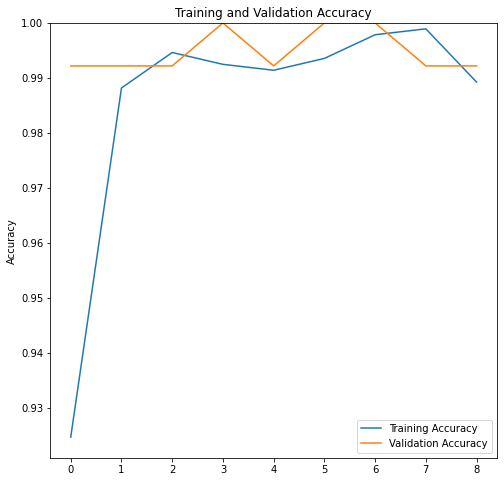

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(1, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation Loss')

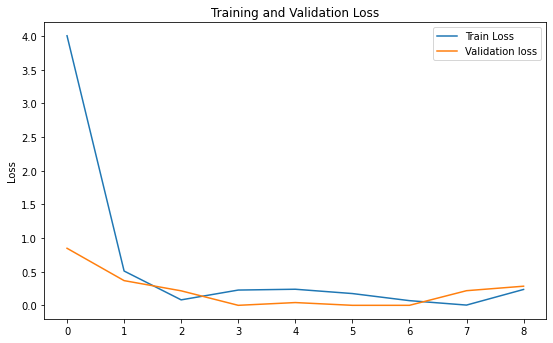

In [19]:
plt.figure(figsize=(9, 12))
plt.subplot(2, 1, 1)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')

plt.title('Training and Validation Loss')

**Evaluate baseline test accuracy and save the model for later usage.**

In [20]:
# Store file 
import tempfile
_, baseline_model_accuracy = model.evaluate_generator(
    validdata, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)
_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print(f'Baseline model saved: {keras_file}')

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Baseline test accuracy: 0.9928571581840515
Baseline model saved: /tmp/tmp7e7qo_lo.h5


**We will apply pruning to the whole model and see this in the model summary.**

**here, we will start the model with 30% sparsity (30% zeros in weights) and end with 40% sparsity. you can increase sparsity according to our needs**

In [21]:
# Load functionality for adding pruning wrappers
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

In [23]:
# Finish pruning after 5 epochs
validation_split = 0.2
num_images = 10500
pruning_epochs=3
end_step = np.ceil(num_images / batch_size).astype(np.int32) * pruning_epochs

# Define pruning configuration
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.30,
                                                               final_sparsity=0.40,
                                                               begin_step=0,
                                                               end_step=end_step)
}
model_for_pruning = prune_low_magnitude(model, **pruning_params)

/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


**Fine tune with pruning for two epochs.**

*   tfmot.sparsity.keras.UpdatePruningStep is required during training
*   tfmot.sparsity.keras.PruningSummaries provides logs for tracking progress  and debugging.





In [24]:
# Recompile the model
model_for_pruning.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])
logdir = tempfile.mkdtemp()
# Model callbacks
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

# Fitting data
model_for_pruning.fit(traindata,
                      batch_size=32,
                      epochs=pruning_epochs,
                      verbose=1,
                      validation_data=validdata,
                      callbacks=callbacks)

Epoch 1/3
31/31 [==============================] - 26s 557ms/step - loss: 0.3836 - accuracy: 0.9917 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/3
31/31 [==============================] - 16s 518ms/step - loss: 0.3644 - accuracy: 0.9917 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/3
31/31 [==============================] - 16s 521ms/step - loss: 0.0890 - accuracy: 0.9958 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


**let's compare model accuracy after prunning with baseline model accuracy.** ****
**we can see that there is not much difference**

In [25]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(
   validdata, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy) 
print('Pruned test accuracy:', model_for_pruning_accuracy)

Baseline test accuracy: 0.9928571581840515
Pruned test accuracy: 1.0


**tfmot.sparsity.keras.strip_pruning and applying a standard compression algorithm (e.g. via gzip) are necessary to see the compression benefits of pruning.**

*   strip_pruning is necessary since it removes every tf.Variable that pruning only needs during training, which would otherwise add to model size during inference
*   Applying a standard compression algorithm is necessary since the serialized weight matrices are the same size as they were before pruning. However, pruning makes most of the weights zeros, which is added redundancy that algorithms can utilize to further compress the model.



In [26]:
import tempfile
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_pruning, pruned_keras_file, include_optimizer=False)

In [27]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
  f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

INFO:tensorflow:Assets written to: /tmp/tmp2ii3a865/assets
Saved pruned TFLite model to: /tmp/tmpcenly4ji.tflite


In [28]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

**Compare and see how the model size has decreased.**

In [29]:
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))
print("Size of gzipped pruned TFlite model: %.2f bytes" % (get_gzipped_model_size(pruned_tflite_file)))

Size of gzipped baseline Keras model: 103238876.00 bytes
Size of gzipped pruned Keras model: 103379615.00 bytes
Size of gzipped pruned TFlite model: 103224512.00 bytes


In [ ]:
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))

Size of gzipped pruned Keras model: 48839882.00 bytes


**lets see the name and place where the model has been stored**

In [30]:
pruned_tflite_file

'/tmp/tmpcenly4ji.tflite'

**we can further reduce the size of the model by employing the meathod of quantization. lets see how its done**

In [31]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_pruned_tflite_model = converter.convert()

_, quantized_and_pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(quantized_and_pruned_tflite_file, 'wb') as f:
  f.write(quantized_and_pruned_tflite_model)

print('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file)

print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_pruned_tflite_file)))

INFO:tensorflow:Assets written to: /tmp/tmpikuqdcrd/assets


INFO:tensorflow:Assets written to: /tmp/tmpikuqdcrd/assets


Saved quantized and pruned TFLite model to: /tmp/tmp8ofz76y0.tflite
Size of gzipped baseline Keras model: 103238876.00 bytes
Size of gzipped pruned and quantized TFlite model: 22771448.00 bytes


**lets see the name of quantized model and place where it is stored**

**lets see the size of the quantized model now**

In [45]:
# Save quantized model
_, quantized_and_pruned_tflite_file = tempfile.mkstemp('.tflite')
tflite_model = converter.convert()
with open(quantized_and_pruned_tflite_file, 'wb') as f:
  f.write(tflite_model)
  
# Additional details
print("Size of gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_pruned_tflite_file)))


INFO:tensorflow:Assets written to: /tmp/tmply2j49ez/assets


INFO:tensorflow:Assets written to: /tmp/tmply2j49ez/assets


Size of gzipped pruned and quantized TFlite model: 22771448.00 bytes


**here we will change current location to the place where the model is stored..so that we can load the model and make inference from it**

In [46]:
%cd /tmp

/tmp


**loading the model**

**making inference from tflite model involves a few steps such as building the interpreter, and allocating tensors, as described in the following sections.**

In [49]:
quantized_and_pruned_tflite_file

'/tmp/tmp2d5cska_.tflite'

In [50]:
interpreter = tf.lite.Interpreter(model_path="/tmp/tmp2d5cska_.tflite")

In [51]:
interpreter.allocate_tensors()

In [52]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']
input_shape

array([  1, 224, 224,   3], dtype=int32)

**below code will tell us about the kind of input tflite model is expecting for giving inference**

In [53]:
input_details

[{'dtype': numpy.float32,
  'index': 0,
  'name': 'model_2_input',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([  1, 224, 224,   3], dtype=int32),
  'shape_signature': array([ -1, 224, 224,   3], dtype=int32),
  'sparsity_parameters': {}}]

In [54]:
%cd /content/

/content


Saving PLANE1.jpg to PLANE1 (1).jpg


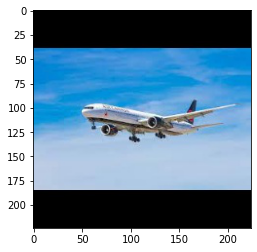

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(224, 224))
  img = np.asarray(img,dtype=np.float32)
  plt.imshow(img)
  img = np.expand_dims(img, axis=0)

In [56]:
img.shape


(1, 224, 224, 3)

**below code is for testing the model**

In [57]:
interpreter.set_tensor(input_details[0]['index'],img )

In [58]:

interpreter.invoke()

In [59]:
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[1. 0.]]


In [62]:
a=output_data[0]

pos=np.argmax(a)

if pos==0:
  print("plane")
elif pos==1:
  print("car")


plane


**I Am Still Working On Improving Latency During Inference**
**expect Update on this soon**